In [1]:
# Make sure to install the following libraries:
# pip install numpy pandas matplotlib seaborn statsmodels arch scikit-learn scipy cython tslearn requests lxml yfinance"
# beautifulsoup4, frozendict, html5lib, lxml, multitasking, numpy, pandas, peewee, platformdirs, pytz, requests

In [2]:
# Core libraries
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Statistical modeling and time series
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA

# Machine Learning
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

# Statistical utilities
from scipy.stats import zscore

# Dynamic time warping for time series
from tslearn.metrics import dtw

In [3]:
# PREPROCESSING

print("\nLoading datasets...")

# Load the datasets
sp500_index = pd.read_csv('sp500_index.csv')
sp500_stocks = pd.read_csv('sp500_stocks.csv')
sp500_companies = pd.read_csv('sp500_companies.csv')

# Parse date columns
sp500_index['Date'] = pd.to_datetime(sp500_index['Date'])
sp500_stocks['Date'] = pd.to_datetime(sp500_stocks['Date'])


Loading datasets...


In [4]:
# Verify data structure
print("Stocks Data Overview:")
print(sp500_stocks.info())
print("\nCompanies Data Overview:")
print(sp500_companies.info())
print("\nIndex Data Overview:")
print(sp500_index.info())

Stocks Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1817339 entries, 0 to 1817338
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Date       datetime64[ns]
 1   Symbol     object        
 2   Adj Close  float64       
 3   Close      float64       
 4   High       float64       
 5   Low        float64       
 6   Open       float64       
 7   Volume     float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 110.9+ MB
None

Companies Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Exchange             503 non-null    object 
 1   Symbol               503 non-null    object 
 2   Shortname            503 non-null    object 
 3   Longname             503 non-null    object 
 4   Sector               503 non-null    objec

In [5]:
sp500_stocks = pd.read_csv('sp500_stocks.csv')
# sp500_stocks = pd.read_csv('V960/sp500_stocks.csv')
sp500_stocks['Date'] = pd.to_datetime(sp500_stocks['Date'])


# Step 1: Identify stocks with no data (all NaN in relevant columns)
relevant_columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
stocks_with_no_data = sp500_stocks.groupby('Symbol').filter(lambda x: x[relevant_columns].isna().all().all())
stocks_with_no_data_symbols = stocks_with_no_data['Symbol'].unique()

print(f"Stocks with no data (0% coverage): {list(stocks_with_no_data_symbols)}")
print(f"Number of stocks with no data: {len(stocks_with_no_data_symbols)}")

# Filter the companies dataset for stocks with no data
no_data_companies = sp500_companies[sp500_companies['Symbol'].isin(stocks_with_no_data_symbols)]

# Sort the stocks by weight in descending order
no_data_companies_sorted = no_data_companies.sort_values(by='Weight', ascending=False)

# Select the top 10 stocks by weight
top_10_no_data_stocks = no_data_companies_sorted.head(10)

# Print the results
print("Top 10 stocks with no data (by weight in S&P 500):")
print(top_10_no_data_stocks[['Symbol', 'Longname', 'Weight']])

# Calculate the total weight of stocks with no data
total_missing_weight = no_data_companies['Weight'].sum()

# Calculate the total weight of the S&P 500 index (should ideally sum to 1.0 or 100%)
total_sp500_weight = sp500_companies['Weight'].sum()

# Calculate the percentage of missing weight
percentage_missing_weight = (total_missing_weight / total_sp500_weight) * 100

# Print the result
print(f"Percentage of S&P 500 weight with no data: {percentage_missing_weight:.2f}%")



Stocks with no data (0% coverage): []
Number of stocks with no data: 0
Top 10 stocks with no data (by weight in S&P 500):
Empty DataFrame
Columns: [Symbol, Longname, Weight]
Index: []
Percentage of S&P 500 weight with no data: 0.00%


C:\Users\coboz\AppData\Local\Temp\ipykernel_25348\3880768726.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_stocks_cleaned['Return'] = sp500_stocks_cleaned.groupby('Symbol')['Close'].pct_change()


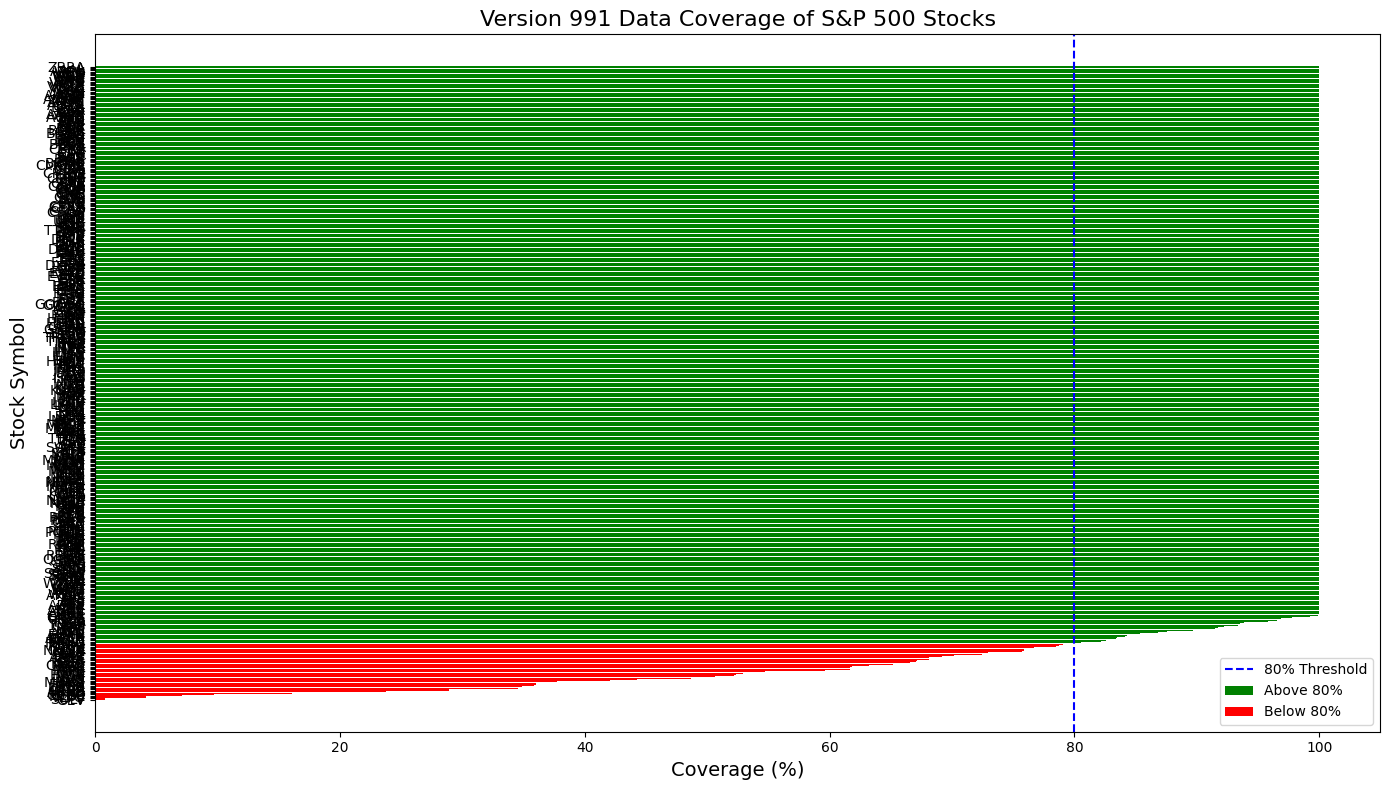

In [6]:
# Step 2: Remove rows with all NaN values in relevant columns for processing
sp500_stocks_cleaned = sp500_stocks.dropna(subset=relevant_columns, how='all')

# Step 3: Compute daily returns for stocks
sp500_stocks_cleaned['Return'] = sp500_stocks_cleaned.groupby('Symbol')['Close'].pct_change()

# Step 4: Pivot data for all stocks
return_matrix = sp500_stocks_cleaned.pivot(index='Date', columns='Symbol', values='Return')

# Step 5: Calculate data coverage for all stocks
data_coverage = (return_matrix.count() / len(return_matrix)) * 100  # Percentage of available data

# Step 6: Visualize data coverage
# Filter and sort data coverage
data_coverage_sorted = data_coverage.sort_values(ascending=False)
above_threshold = data_coverage_sorted[data_coverage_sorted >= 80]
below_threshold = data_coverage_sorted[data_coverage_sorted < 80]

# Plot horizontal bar chart
plt.figure(figsize=(14, 8))
plt.barh(above_threshold.index, above_threshold.values, color='green', label='Above 80%')
plt.barh(below_threshold.index, below_threshold.values, color='red', label='Below 80%')

plt.axvline(x=80, color='blue', linestyle='--', label='80% Threshold')
plt.title('Version 991 Data Coverage of S&P 500 Stocks', fontsize=16)
plt.xlabel('Coverage (%)', fontsize=14)
plt.ylabel('Stock Symbol', fontsize=14)
plt.legend()
plt.gca().invert_yaxis()  # Invert Y-axis for better readability
plt.tight_layout()
plt.show()

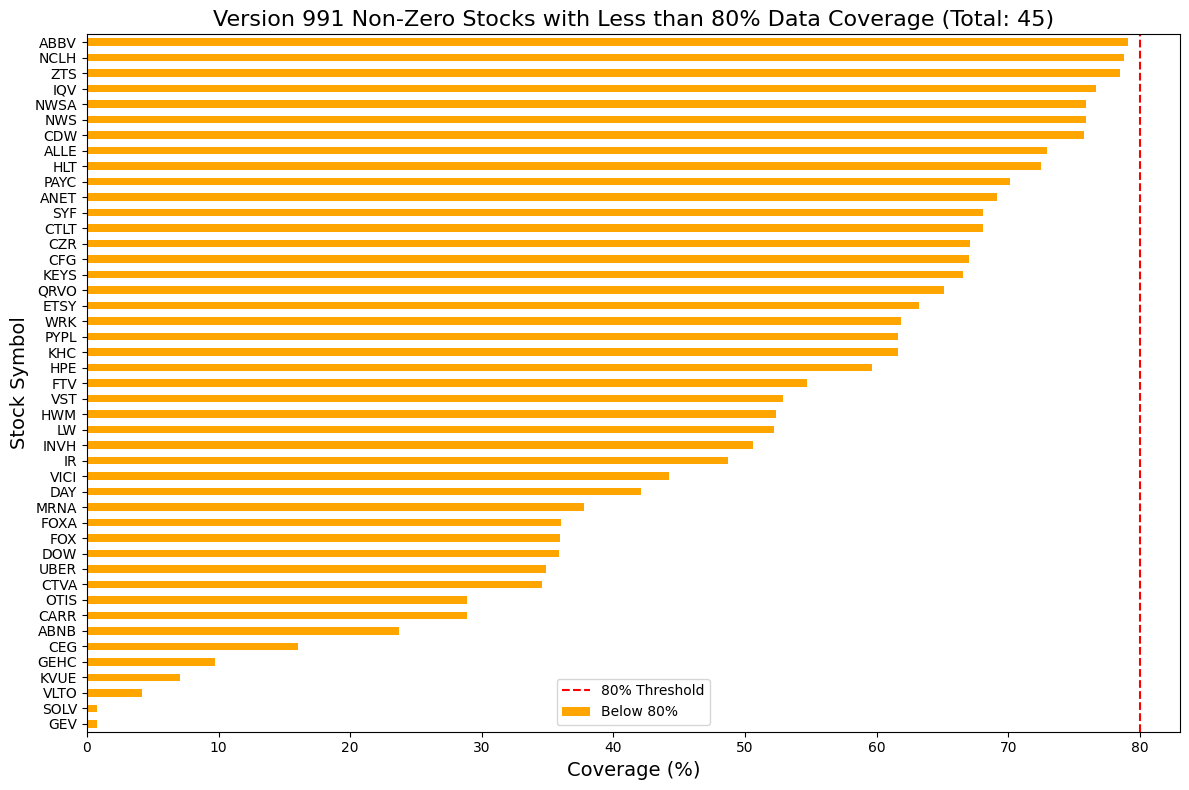

In [7]:
# Filter stocks below 80% coverage
below_threshold = data_coverage[data_coverage < 80]

# Plot only stocks below 80% coverage
plt.figure(figsize=(12, 8))
below_threshold.sort_values().plot(kind='barh', color='orange', label='Below 80%')
plt.axvline(x=80, color='red', linestyle='--', label='80% Threshold')
plt.title(f'Version 991 Non-Zero Stocks with Less than 80% Data Coverage (Total: {len(below_threshold)})', fontsize=16)
plt.xlabel('Coverage (%)', fontsize=14)
plt.ylabel('Stock Symbol', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


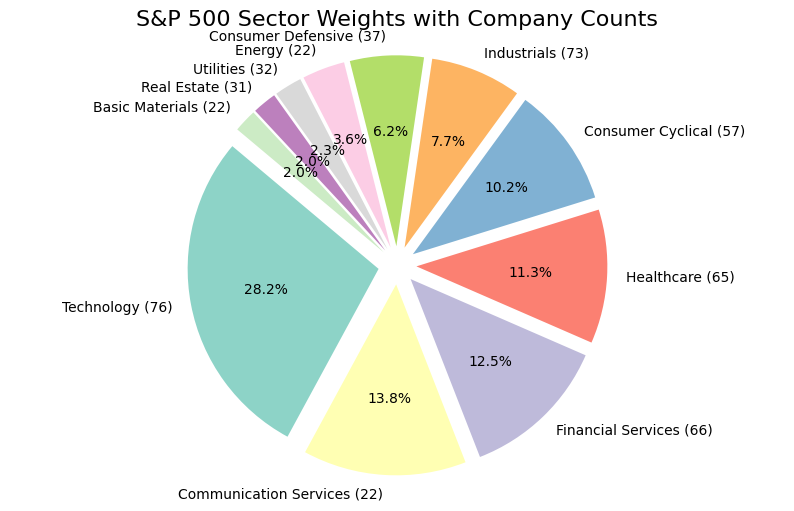

In [8]:
# Calculate sector weights and company counts
sector_weights = sp500_companies.groupby('Sector')['Weight'].sum().sort_values(ascending=False)
sector_counts = sp500_companies['Sector'].value_counts()

# Create labels combining sector names with company counts
sector_labels = [f"{sector} ({sector_counts[sector]})" for sector in sector_weights.index]

# Plot the pie chart
plt.figure(figsize=(10, 6))
sector_colors = sns.color_palette('Set3', n_colors=len(sector_weights))
plt.pie(
    sector_weights,
    labels=sector_labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=sector_colors,
    explode=[0.1] * len(sector_weights)  # Explode all slices slightly for emphasis
)

# Add a title and ensure a clean layout
plt.title('S&P 500 Sector Weights with Company Counts', fontsize=16)
plt.axis('equal')  # Ensure the pie chart is a circle
plt.show()

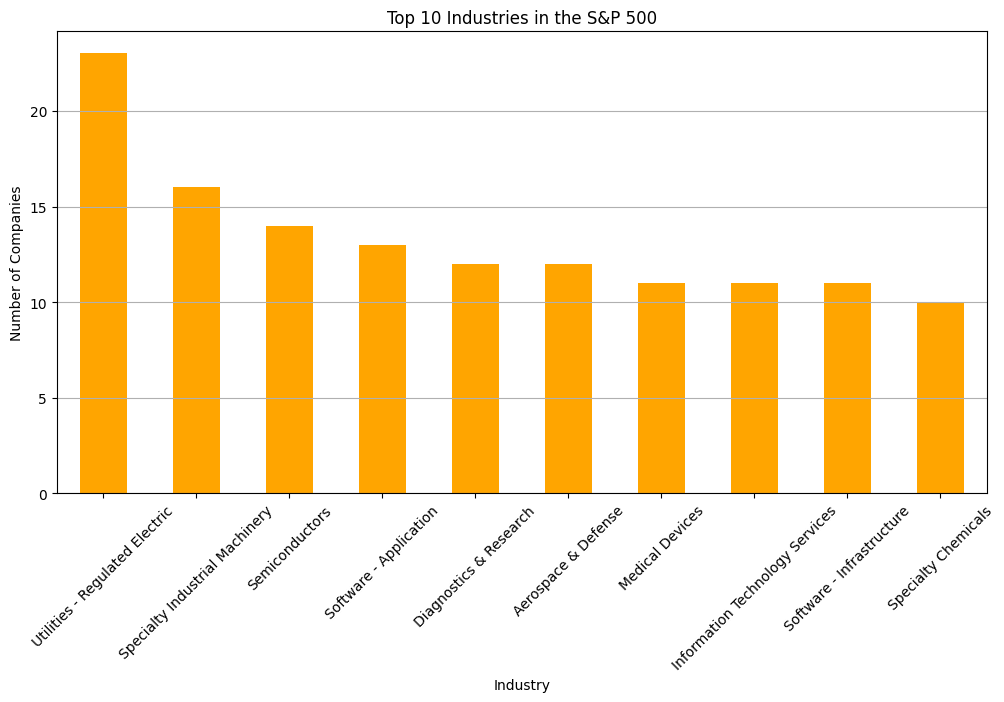

In [9]:
# Visualization 4: Industry Distribution (Bar Chart)
industry_distribution = sp500_companies['Industry'].value_counts().head(10)
plt.figure(figsize=(12, 6))
industry_distribution.plot(kind='bar', color='orange')
plt.title('Top 10 Industries in the S&P 500')
plt.xlabel('Industry')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


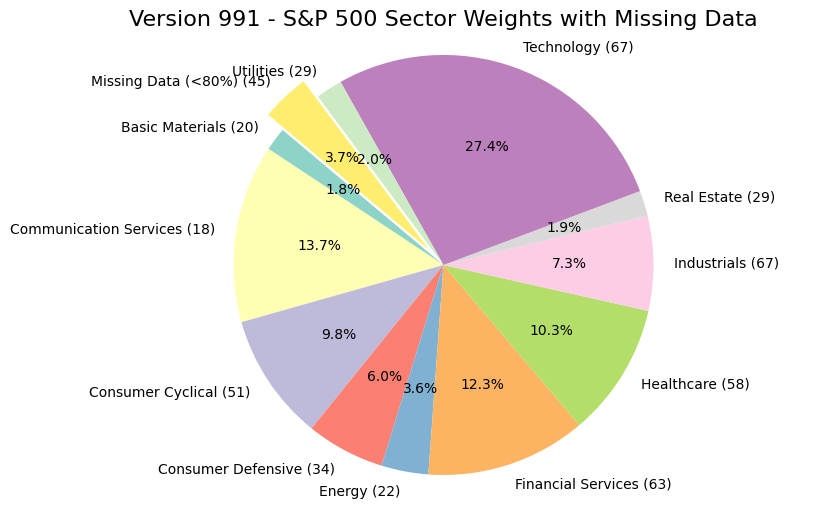

In [10]:
# Load the S&P 500 companies dataset
sp500_companies = pd.read_csv("sp500_companies.csv")  # Replace with your file path

# Calculate sector weights for stocks with >80% data coverage
# (Assuming 'data_coverage' contains percentage data for each stock)
stocks_with_enough_data = data_coverage[data_coverage >= 80].index
enough_data_companies = sp500_companies[sp500_companies['Symbol'].isin(stocks_with_enough_data)]

# Group by sector for stocks with enough data (>= 80%)
enough_data_sector_weights = enough_data_companies.groupby('Sector')['Weight'].sum()
enough_data_sector_counts = enough_data_companies['Sector'].value_counts()

# Calculate total weight and count for stocks with <80% data coverage
missing_data_weight = sp500_companies['Weight'].sum() - enough_data_sector_weights.sum()
missing_data_count = len(sp500_companies) - len(enough_data_companies)

# Combine weights and counts into a single Series
sector_weights_with_missing = pd.concat(
    [enough_data_sector_weights, pd.Series({'Missing Data (<80%)': missing_data_weight})]
)

# Update labels with corrected company counts
sector_labels_with_missing = [
    f"{sector} ({enough_data_sector_counts.get(sector, 0)})"
    for sector in enough_data_sector_weights.index
]
sector_labels_with_missing.append(f"Missing Data (<80%) ({missing_data_count})")

# Plot the updated pie chart
plt.figure(figsize=(10, 6))
sector_colors = sns.color_palette('Set3', n_colors=len(sector_weights_with_missing))
plt.pie(
    sector_weights_with_missing,
    labels=sector_labels_with_missing,
    autopct='%1.1f%%',
    startangle=140,
    colors=sector_colors,
    explode=[0.1 if sector == 'Missing Data (<80%)' else 0 for sector in sector_weights_with_missing.index]
)

# Add a title and ensure a clean layout
plt.title('Version 991 - S&P 500 Sector Weights with Missing Data', fontsize=16)
plt.axis('equal')  # Ensure the pie chart is a circle
plt.show()


C:\Users\coboz\AppData\Local\Temp\ipykernel_25348\1554381391.py:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sp500_stocks['Return'] = sp500_stocks.groupby('Symbol')['Close'].pct_change()


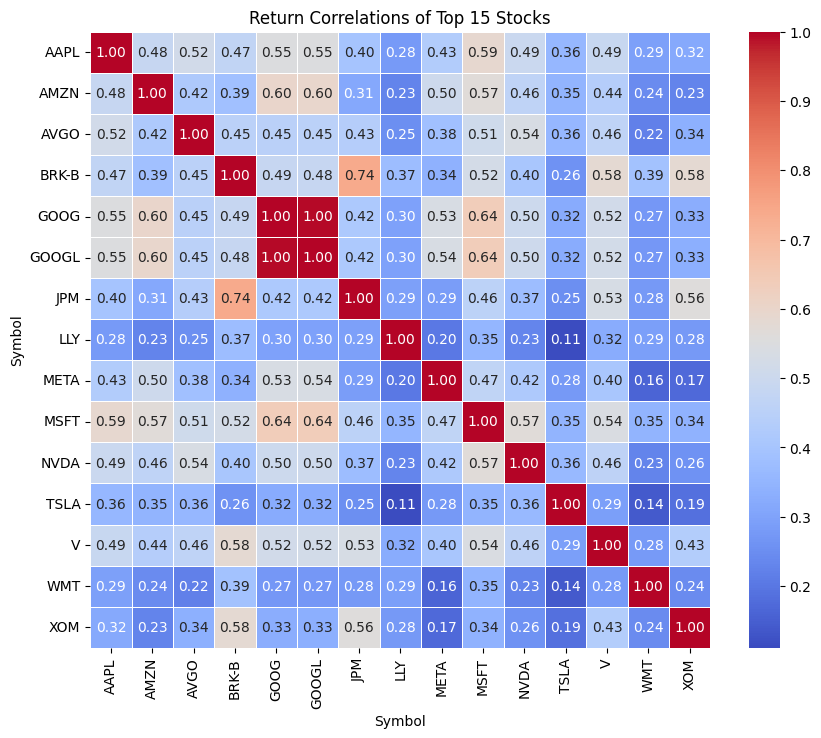

In [11]:
# Compute daily returns
sp500_stocks['Return'] = sp500_stocks.groupby('Symbol')['Close'].pct_change()

# dropping one of the Google's
# sp500_companies_adj = sp500_companies.drop(4, inplace=True)

# Filter for top 15 weighted stocks
top_15_stocks = sp500_companies.nlargest(15, 'Weight')['Symbol']
returns_data = sp500_stocks[sp500_stocks['Symbol'].isin(top_15_stocks)]

# Pivot data for correlation
return_matrix = returns_data.pivot(index='Date', columns='Symbol', values='Return')
return_corr = return_matrix.corr()

# Visualize the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(return_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Return Correlations of Top 15 Stocks')
plt.show()


In [12]:
sp500_index

,Date,S&P500
0,2014-05-12,1896.65
1,2014-05-13,1897.45
2,2014-05-14,1888.53
3,2014-05-15,1870.85
4,2014-05-16,1877.86
...,...,...
2513,2024-05-06,5180.74
2514,2024-05-07,5187.70
2515,2024-05-08,5187.67
2516,2024-05-09,5214.08


C:\Users\coboz\AppData\Local\Temp\ipykernel_25348\361394207.py:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sp500_stocks['Return'] = sp500_stocks.groupby('Symbol')['Close'].pct_change()


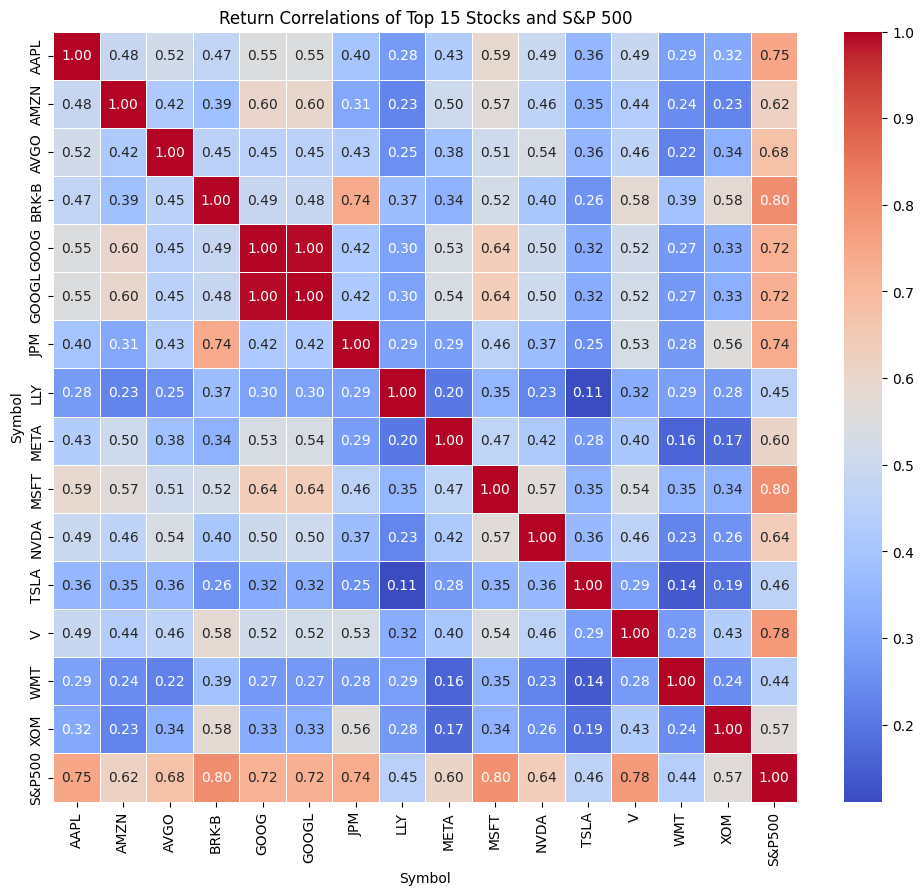

In [13]:
# Compute daily returns for stocks
sp500_stocks['Return'] = sp500_stocks.groupby('Symbol')['Close'].pct_change()

# Compute daily returns for the S&P 500 Index
sp500_index['SP500_Return'] = sp500_index['S&P500'].pct_change()

# Filter for top 15 weighted stocks
top_15_stocks = sp500_companies.nlargest(15, 'Weight')['Symbol']
returns_data = sp500_stocks[sp500_stocks['Symbol'].isin(top_15_stocks)]

# Merge S&P 500 Index returns
returns_data = returns_data.merge(sp500_index[['Date', 'SP500_Return']], on='Date', how='left')

# Pivot data for correlation
return_matrix = returns_data.pivot(index='Date', columns='Symbol', values='Return')
return_matrix['S&P500'] = sp500_index.set_index('Date')['SP500_Return']
return_corr = return_matrix.corr()

# Visualize the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(return_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Return Correlations of Top 15 Stocks and S&P 500')
plt.show()

C:\Users\coboz\AppData\Local\Temp\ipykernel_25348\1276131157.py:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sp500_stocks['Return'] = sp500_stocks.groupby('Symbol')['Close'].pct_change()


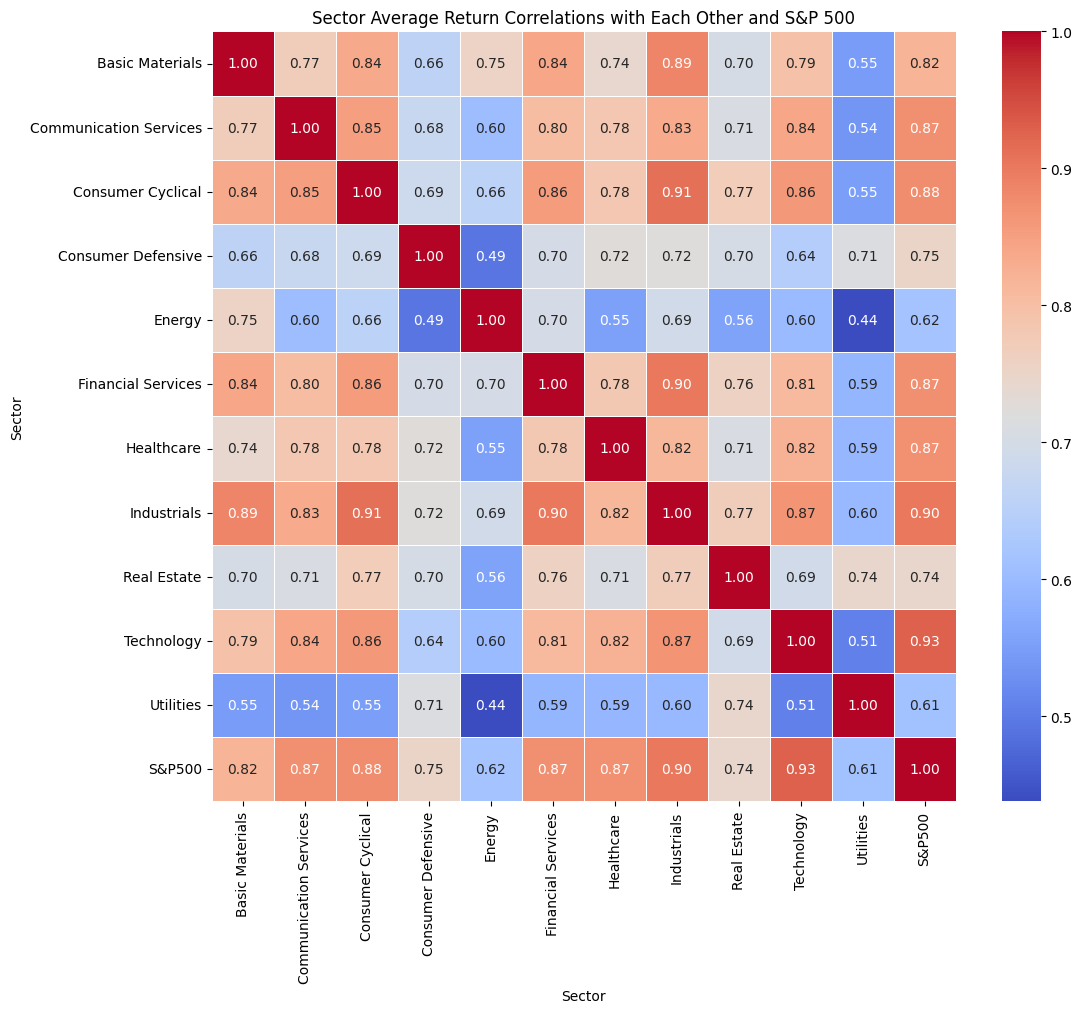

In [14]:
# Compute daily returns for stocks
sp500_stocks['Return'] = sp500_stocks.groupby('Symbol')['Close'].pct_change()

# Add sector information to the stocks data
sector_returns = sp500_stocks.merge(sp500_companies[['Symbol', 'Sector']], on='Symbol', how='left')

# Compute average returns by sector
sector_avg_returns = sector_returns.groupby(['Date', 'Sector'])['Return'].mean().unstack()

# Add S&P 500 returns to the sector data
sector_avg_returns['S&P500'] = sp500_index.set_index('Date')['SP500_Return']

# Compute correlation
sector_corr = sector_avg_returns.corr()

# Visualize the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(sector_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Sector Average Return Correlations with Each Other and S&P 500')
plt.show()


In [15]:
# Clean sp500_stocks
relevant_columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
sp500_stocks_cleaned = sp500_stocks.dropna(subset=relevant_columns, how='all')

# Compute daily returns
sp500_stocks_cleaned['Return'] = sp500_stocks_cleaned.groupby('Symbol')['Close'].pct_change()

# Drop rows with NaN values in 'Return' and 'Volume'
sp500_stocks_cleaned = sp500_stocks_cleaned[['Return', 'Volume']].dropna()

C:\Users\coboz\AppData\Local\Temp\ipykernel_25348\2534465997.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_stocks_cleaned['Return'] = sp500_stocks_cleaned.groupby('Symbol')['Close'].pct_change()


In [19]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Normalize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(sp500_stocks_cleaned)

# # Apply DBSCAN
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# clusters = dbscan.fit_predict(features_scaled)

# # Add cluster labels to the DataFrame
# sp500_stocks_cleaned['Cluster'] = clusters

# # Plot the clustering result
# plt.figure(figsize=(8, 6))
# plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=clusters, cmap='viridis', s=10)
# plt.title('DBSCAN Clustering')
# plt.xlabel('Normalized Return')
# plt.ylabel('Normalized Volume')
# plt.colorbar(label='Cluster')
# plt.show()


In [20]:
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# import matplotlib.pyplot as plt

# # Normalize the data (ensure 'sp500_stocks_cleaned' exists and is preprocessed)
# features = sp500_stocks_cleaned[['Return', 'Volume']].dropna()  # Ensure no NaNs
# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features)

# # DBSCAN clustering
# dbscan = DBSCAN(eps=0.5, min_samples=10)  # Adjust eps and min_samples as needed
# dbscan_clusters = dbscan.fit_predict(features_scaled)

# # Add DBSCAN cluster labels to the DataFrame
# sp500_stocks_cleaned['DBSCAN_Cluster'] = dbscan_clusters

# # Plot the DBSCAN clustering result
# plt.figure(figsize=(8, 6))
# plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=dbscan_clusters, cmap='viridis', s=10)
# plt.title('DBSCAN Clustering')
# plt.xlabel('Normalized Return')
# plt.ylabel('Normalized Volume')
# plt.colorbar(label='Cluster')
# plt.show()


c:\Users\coboz\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\coboz\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\coboz\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\coboz\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  

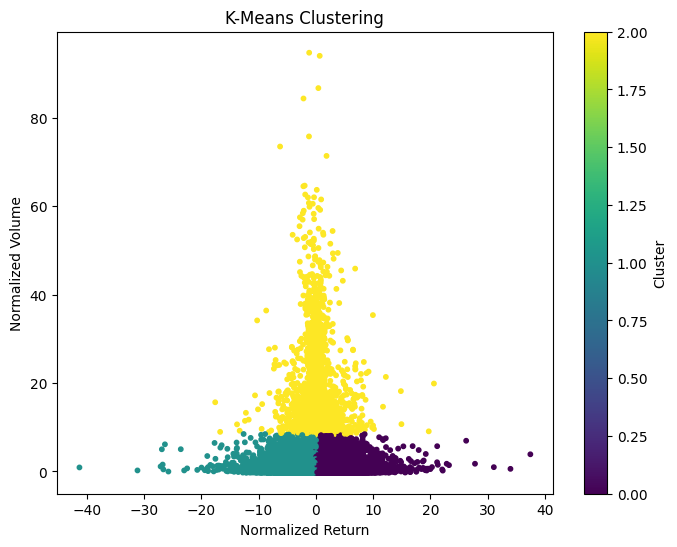

In [21]:
from sklearn.cluster import KMeans

# Apply K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_clusters = kmeans.fit_predict(features_scaled)

# Add cluster labels to the DataFrame
sp500_stocks_cleaned['KMeans_Cluster'] = kmeans_clusters

# Plot the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=kmeans_clusters, cmap='viridis', s=10)
plt.title('K-Means Clustering')
plt.xlabel('Normalized Return')
plt.ylabel('Normalized Volume')
plt.colorbar(label='Cluster')
plt.show()


In [22]:
from sklearn.metrics import silhouette_score

# For K-Means
kmeans_score = silhouette_score(features_scaled, kmeans_clusters)
print("Silhouette Score for K-Means:", kmeans_score)

# # For DBSCAN (using the subset)
# dbscan_score = silhouette_score(features_scaled_subset, dbscan_clusters)
# print("Silhouette Score for DBSCAN (subset):", dbscan_score)


KeyboardInterrupt: 

In [23]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Define the features and target
X = sp500_stocks_cleaned[['Return', 'Volume']].dropna()
y = (X['Return'] > 0).astype(int)  # Binary target

# Random Forest as the base model
model = RandomForestClassifier(random_state=42)

# Perform Recursive Feature Elimination
rfe = RFE(model, n_features_to_select=1)
rfe.fit(X, y)

# Display feature ranking
for i, feature in enumerate(X.columns):
    print(f"Feature: {feature}, Rank: {rfe.ranking_[i]}")


Feature: Return, Rank: 1
Feature: Volume, Rank: 2


In [24]:
from sklearn.linear_model import LassoCV

# Lasso Regression for feature selection
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X, y)

# Display coefficients
selected_features = X.columns[lasso.coef_ != 0]
print("Selected Features:", selected_features)


Selected Features: Index(['Volume'], dtype='object')


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    166060
           1       1.00      1.00      1.00    179552

    accuracy                           1.00    345612
   macro avg       1.00      1.00      1.00    345612
weighted avg       1.00      1.00      1.00    345612



In [27]:
# Limit tree depth and number of estimators
rf_tuned = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_tuned.fit(X_train, y_train)

# Evaluate the tuned model
y_pred_tuned = rf_tuned.predict(X_test)
print("Accuracy (Tuned Random Forest):", accuracy_score(y_test, y_pred_tuned))
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))


Accuracy (Tuned Random Forest): 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    166060
           1       1.00      1.00      1.00    179552

    accuracy                           1.00    345612
   macro avg       1.00      1.00      1.00    345612
weighted avg       1.00      1.00      1.00    345612



In [ ]:
from sklearn.model_selection import cross_val_score

# Random Forest with all features
rf_all_features = RandomForestClassifier(random_state=42)
all_features_score = cross_val_score(rf_all_features, X, y, cv=5, scoring='accuracy').mean()
print("Cross-Validation Accuracy with All Features:", all_features_score)

# Random Forest with RFE-selected features
X_rfe = X[['Return']]  # RFE suggested 'Return' as the top feature
rfe_features_score = cross_val_score(rf_all_features, X_rfe, y, cv=5, scoring='accuracy').mean()
print("Cross-Validation Accuracy with RFE-Selected Features:", rfe_features_score)

# Random Forest with Lasso-selected features - COULDN'T RETRIEVE TOOK TOO LONG
X_lasso = X[['Volume']]  # Lasso suggested 'Volume' as the selected feature
lasso_features_score = cross_val_score(rf_all_features, X_lasso, y, cv=5, scoring='accuracy').mean()
print("Cross-Validation Accuracy with Lasso-Selected Features:", lasso_features_score)


Cross-Validation Accuracy with All Features: 0.9999994213147151
Cross-Validation Accuracy with RFE-Selected Features: 1.0


KeyboardInterrupt: 

In [26]:
from sklearn.neighbors import KNeighborsClassifier

# Train k-NN classifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Make predictions
y_knn_pred = knn_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_knn_pred))
print("Classification Report:\n", classification_report(y_test, y_knn_pred))


Accuracy: 0.8355294376352673
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.83    166060
           1       0.84      0.85      0.84    179552

    accuracy                           0.84    345612
   macro avg       0.84      0.84      0.84    345612
weighted avg       0.84      0.84      0.84    345612



In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'n_neighbors': list(range(1, 21)), 'weights': ['uniform', 'distance']}

# Perform GridSearchCV
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and accuracy
print("Best Parameters for k-NN:", grid_search.best_params_)
print("Best Cross-Validation Accuracy for k-NN:", grid_search.best_score_)


In [ ]:
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime, timedelta
register_matplotlib_converters()

In [ ]:
acf_vals = acf(sp500_index)
num_lags = 10
plt.bar(range(num_lags), acf_vals[:num_lags])
pacf_vals = pacf(sp500_index)
num_lags = 25
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [ ]:
import yfinance as yf

# Specify stock symbol, start, and end date
symbol = "DIS"
start_date = "2010-01-01"
end_date = "2023-01-01"

# Download data using yfinance
dis = yf.download(symbol, start=start_date, end=end_date)

# Display the first few rows
print(dis.head())


[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low   Open    Volume
Ticker            DIS        DIS        DIS        DIS    DIS       DIS
Date                                                                   
2010-01-04  27.715315  32.070000  32.750000  31.870001  32.50  13700400
2010-01-05  27.646179  31.990000  32.160000  31.700001  32.07  10307700
2010-01-06  27.499258  31.820000  32.000000  31.680000  31.90  10709500
2010-01-07  27.507900  31.830000  31.860001  31.540001  31.77   8202100
2010-01-08  27.551113  31.879999  31.940001  31.530001  31.66   7657500


In [ ]:
def load_data(file_path):
    """Load and preprocess S&P 500 index data."""
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    data['daily_return'] = data['S&P500'].pct_change()
    data = data.dropna()  # Drop rows with missing values
    return data

def split_data(data, split_date="2019-01-01"):
    """Split the data into training and testing sets."""
    train_data = data[data['Date'] < split_date]
    test_data = data[data['Date'] >= split_date]
    return train_data, test_data

In [ ]:
def convert_dates(df, date_column):
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    return df

# Helper function: Data cleaning
def clean_data(stocks):
    # Drop rows with missing values or interpolate them
    # stocks.interpolate(method='linear', inplace=True)
    
    # Interpolate only numeric columns
    numeric_cols = stocks.select_dtypes(include=['float64', 'int64']).columns
    stocks[numeric_cols] = stocks[numeric_cols].interpolate(method='linear')
    return stocks

# Helper function: Normalize numerical features
def normalize_features(stocks, columns_to_scale):
    scaler = StandardScaler()
    stocks[columns_to_scale] = scaler.fit_transform(stocks[columns_to_scale])
    return stocks

# Helper function: Feature engineering
def add_features(stocks):
    # Calculate daily returns
    stocks['daily_return'] = stocks['Close'].pct_change()

    # Add moving averages
    stocks['MA_10'] = stocks['Close'].rolling(window=10).mean()
    stocks['MA_50'] = stocks['Close'].rolling(window=50).mean()

    # Calculate rolling volatility
    stocks['volatility'] = stocks['daily_return'].rolling(window=10).std()

    return stocks

def optimize_memory(df):
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df